# Import Packages

In [35]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns

# Connect to MySQL

In [3]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

# Get box scores

In [4]:
select_statement = """SELECT * FROM nba.box_score;"""
cursor.execute(select_statement)
nba_data = cursor.fetchall()

In [5]:
nba_df = pd.DataFrame(nba_data)
field_names = [i[0] for i in cursor.description]
nba_df.columns = field_names

In [6]:
nba_df_played = nba_df[nba_df['MIN'].notnull()]

In [7]:
nba_df_played.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57287 entries, 3 to 67817
Data columns (total 34 columns):
GAME_ID              57287 non-null object
TEAM_ID              57287 non-null float64
TEAM_ABBREVIATION    57287 non-null object
TEAM_CITY            57287 non-null object
PLAYER_ID            57287 non-null float64
PLAYER_NAME          57287 non-null object
START_POSITION       57287 non-null object
COMMENT              57287 non-null object
MIN                  57287 non-null object
FGM                  57287 non-null float64
FGA                  57287 non-null float64
FG_PCT               57287 non-null float64
FG3M                 57287 non-null float64
FG3A                 57287 non-null float64
FG3_PCT              57287 non-null float64
FTM                  57287 non-null float64
FTA                  57287 non-null float64
FT_PCT               57287 non-null float64
OREB                 57287 non-null float64
DREB                 57287 non-null float64
REB               

In [9]:
nba_df_played.shape

(57287, 34)

# Create second variable

In [12]:
nba_df_played.reset_index(drop = True, inplace = True)
nba_df_played['SEC'] = 0
for i in range(0, len(nba_df_played)):
    minutes = nba_df_played.loc[i, 'MIN']
    nba_df_played.at[i, 'SEC'] = int(minutes.split(':')[0])*60 + int(minutes.split(':')[1])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Get Trailing Averages for Last 3 Games

In [13]:
# Get average from last trail_len
def get_trailing_avg(df, col_name, trail_len):
    new_col = col_name + '_TRAIL' + str(trail_len)
    df[new_col] = None
    for i in range(0, trail_len):
        df.at[i, new_col] = 'game' + str(i + 1)
    for index in range(trail_len, len(df)):
        df.at[index, new_col] = np.mean(df.loc[index-trail_len:index-1, col_name])

In [14]:
nba_trailing = []
for season in set(nba_df_played['SEASON_ID']):
    for player in set(nba_df_played['PLAYER_ID']):
        games_played = nba_df_played[(nba_df_played['PLAYER_ID'] == player) & 
                                     (nba_df_played['SEASON_ID'] == season)]
        games_played = games_played.sort_values(by = ['GAME_ID'])
        games_played.reset_index(drop = True, inplace = True)
                      
        # Group 1: Field Goals
        get_trailing_avg(games_played, 'FGM', 3)
        get_trailing_avg(games_played, 'FGA', 3)
        get_trailing_avg(games_played, 'FG_PCT', 3)
        
        # Group 2: Three-Pointers
        get_trailing_avg(games_played, 'FG3M', 3)
        get_trailing_avg(games_played, 'FG3A', 3)
        get_trailing_avg(games_played, 'FG3_PCT', 3)

        # Group 3: Free Throws
        get_trailing_avg(games_played, 'FTM', 3)
        get_trailing_avg(games_played, 'FTA', 3)
        get_trailing_avg(games_played, 'FT_PCT', 3)

        # Group 4: Rebounds
        get_trailing_avg(games_played, 'OREB', 3)
        get_trailing_avg(games_played, 'DREB', 3)
        get_trailing_avg(games_played, 'REB', 3)
        
        # Group 5: Miscellaneous
        get_trailing_avg(games_played, 'PTS', 3)
        get_trailing_avg(games_played, 'STL', 3)
        get_trailing_avg(games_played, 'AST', 3)            
        get_trailing_avg(games_played, 'BLK', 3)
        get_trailing_avg(games_played, 'TOS', 3)
        get_trailing_avg(games_played, 'doubles', 3)
        get_trailing_avg(games_played, 'SEC', 3)
                      
        nba_trailing.append(games_played)

In [15]:
nba_trailing_df = pd.concat(nba_trailing)

In [16]:
nba_trailing_played = nba_trailing_df[nba_trailing_df['MIN'].notnull()]

In [17]:
nba_trailing_played.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'SEC',
       'FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3',
       'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3',
       'FT_PCT_TRAIL3', 'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3',
       'PTS_TRAIL3', 'STL_TRAIL3', 'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3',
       'doubles_TRAIL3', 'SEC_TRAIL3'],
      dtype='object')

In [41]:
nba_trailing_played.to_csv('NBA_box_scores_trailing3.csv')

In [18]:
stats_sub = nba_trailing_played[['FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 
                                  'FG3M_TRAIL3', 'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 
                                  'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3', 'OREB_TRAIL3', 
                                  'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3',
                                  'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3', 
                                  'SEC_TRAIL3', 'DK_PTS']]

In [19]:
stats_sub.reset_index(drop = True, inplace = True)

In [20]:
stats_sub = stats_sub.replace({'game1': None, 'game2': None, 'game3': None})

In [21]:
stats_sub.DK_PTS.describe()

count    57287.00000
mean        21.25381
std         14.37927
min         -1.50000
25%         10.25000
50%         19.25000
75%         30.00000
max        102.00000
Name: DK_PTS, dtype: float64

## Power Transform Variables

In [22]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
variables = ['FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 
             'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3', 
             'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3',
             'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3', 'DK_PTS']

stats_sub_transform = stats_sub.copy()
# stats_sub_transform[variables] = stats_sub[variables].apply(StandardScaler)

In [23]:
scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
scaler.fit(stats_sub[variables])
stats_sub_transform[variables] = scaler.transform(stats_sub[variables])

In [24]:
scaler.lambdas_

array([ 0.28138728,  0.38246308,  1.53985973, -0.36248259,  0.22490021,
       -0.20002773, -0.28941976, -0.12613955,  0.58164481, -0.64094182,
        0.11941519,  0.12680274,  0.36944383, -0.44517502, -0.19285802,
       -1.43300874, -0.15456539,  0.50701215])

In [26]:
all_vars = ['FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 
            'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 
            'FT_PCT_TRAIL3', 'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 
            'PTS_TRAIL3', 'STL_TRAIL3', 'AST_TRAIL3', 'BLK_TRAIL3', 
            'TOS_TRAIL3', 'doubles_TRAIL3', 'SEC_TRAIL3', 'DK_PTS']

vars_of_interest = ['FGA_TRAIL3', 'AST_TRAIL3', 'TOS_TRAIL3', 'REB_TRAIL3', 'DK_PTS']

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


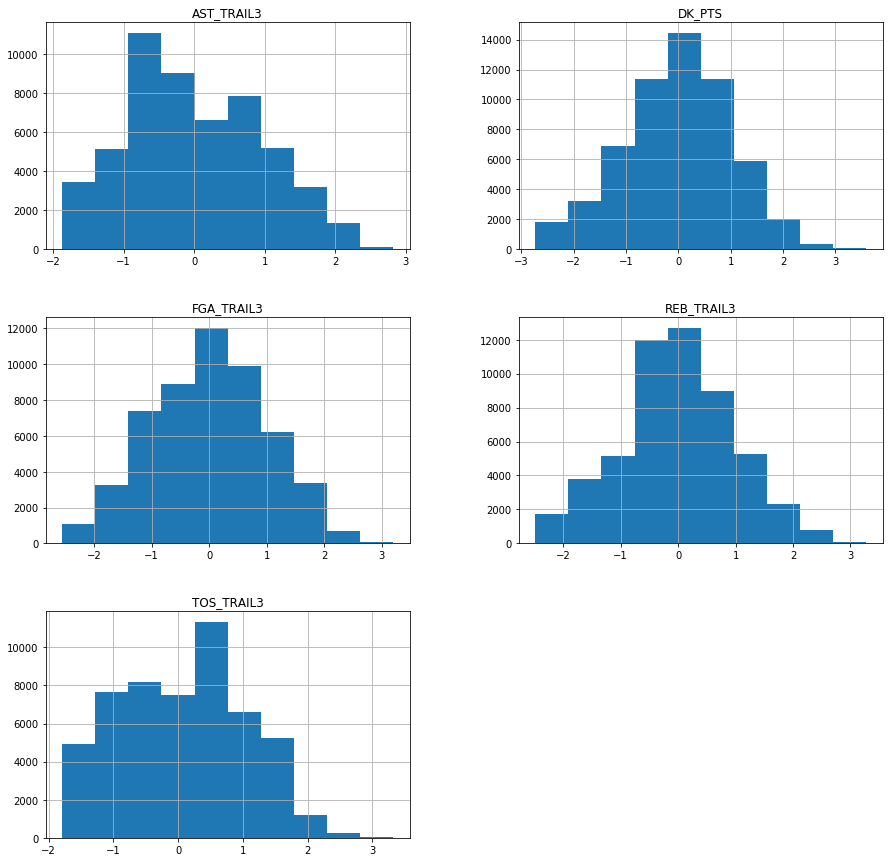

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
stats_sub_transform[vars_of_interest].hist(ax = ax);

# Run regression on test data

In [28]:
lm_attempt1 = stats_sub_transform[vars_of_interest]
lm_attempt1.dropna(inplace = True)

outcome = 'DK_PTS'
Y = lm_attempt1[['DK_PTS']]
predictors = lm_attempt1.drop('DK_PTS', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
X_train, X_test, y_train, y_test = train_test_split(predictors, Y, test_size=0.30, random_state=34567)

In [30]:
train_data = pd.concat([X_train, y_train], axis = 1)

In [31]:
train_data.describe()

,FGA_TRAIL3,AST_TRAIL3,TOS_TRAIL3,REB_TRAIL3,DK_PTS
count,37006.000000,37006.000000,37006.000000,37006.000000,37006.000000
mean,0.003035,0.004197,0.000027,-0.000210,0.030864
std,1.001091,0.998890,0.996711,1.000881,0.986886
min,-2.557359,-1.871336,-1.790779,-2.484818,-2.730276
25%,-0.657031,-0.850986,-0.510512,-0.741389,-0.631237
50%,0.034462,0.003048,-0.077496,0.031184,0.071442
75%,0.700522,0.680106,0.842842,0.687210,0.718694
max,3.141788,2.776074,3.259124,3.272702,3.547786


In [32]:
model = ols(formula=formula, data=train_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DK_PTS   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     9079.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:43:12   Log-Likelihood:                -39367.
No. Observations:               37006   AIC:                         7.874e+04
Df Residuals:                   37001   BIC:                         7.879e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0292      0.004      8.009      0.000       0.022       0.036
FGA_TRAIL3     0.3936      0.006     69.915      0.000       0.383       0.405
AST_TRAIL3     0.1244      0.005     24.855      0.000       0.115       0.134
TOS_TRAIL3     0.0879      0.005     17.376      0.000       0.078       0.098
REB_TRAIL3     0.2245      0.004     50.419      0.000       0.216       0.233
==============================================================================
Omnibus:                      122.993   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.209
Skew:                          -0.112   Prob(JB):                     1.96e-29
Kurtosis:                       3.190   Cond. No.                         2.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
corr_test = train_data[vars_of_interest].corr()

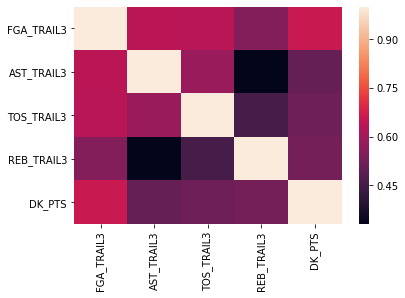

In [36]:
sns.heatmap(corr_test)

In [37]:
corr_test

,FGA_TRAIL3,AST_TRAIL3,TOS_TRAIL3,REB_TRAIL3,DK_PTS
FGA_TRAIL3,1.000000,0.637491,0.634214,0.553990,0.661954
AST_TRAIL3,0.637491,1.000000,0.589393,0.330958,0.508089
TOS_TRAIL3,0.634214,0.589393,1.000000,0.456205,0.520080
REB_TRAIL3,0.553990,0.330958,0.456205,1.000000,0.531007
DK_PTS,0.661954,0.508089,0.520080,0.531007,1.000000


# Run regression on test data

In [38]:
test_data = pd.concat([X_test, y_test], axis = 1)
model = ols(formula=formula, data=test_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DK_PTS   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     3795.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:43:54   Log-Likelihood:                -16969.
No. Observations:               15860   AIC:                         3.395e+04
Df Residuals:                   15855   BIC:                         3.399e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0311      0.006      5.545      0.000       0.020       0.042
FGA_TRAIL3     0.3861      0.009     44.589      0.000       0.369       0.403
AST_TRAIL3     0.1247      0.008     16.351      0.000       0.110       0.140
TOS_TRAIL3     0.0922      0.008     11.906      0.000       0.077       0.107
REB_TRAIL3     0.2241      0.007     32.627      0.000       0.211       0.238
==============================================================================
Omnibus:                       67.598   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.356
Skew:                          -0.126   Prob(JB):                     1.18e-16
Kurtosis:                       3.218   Cond. No.                         2.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

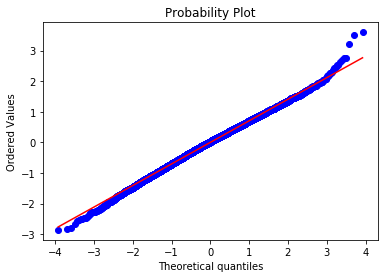

In [39]:
figure = plt.figure()
ax = figure.gca()
stats.probplot(model.resid, dist = 'norm', plot = ax)
plt.show()

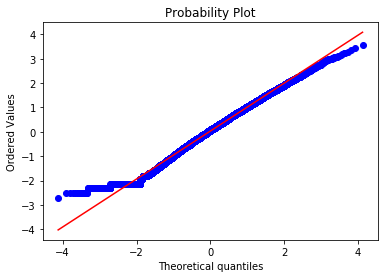

In [40]:
figure = plt.figure()
ax = figure.gca()
stats.probplot(train_data['DK_PTS'], dist='norm', plot = ax)
plt.show()

In [306]:
corr_unstack = corr_matrix.unstack()
sorted_corr = corr_unstack.sort_values(kind="quicksort")

corr_df = pd.DataFrame(sorted_corr)
corr_df.columns = ['correlation']
print(corr_df[(corr_df['correlation'].abs() > 0.3) & (corr_df['correlation'].abs() < 1)])
corr_df_index = corr_df.reset_index()
# print(corr_df_index[corr_df_index['level_0'] == 'SEC'].sort_values(by = 'correlation', ascending = False))
print(corr_df_index[corr_df_index['level_0'] == 'DK_PTS'].sort_values(by = 'correlation', ascending = False))

                       correlation
REB_TRAIL3 AST_TRAIL3     0.334042
AST_TRAIL3 REB_TRAIL3     0.334042
           DK_PTS         0.507681
DK_PTS     AST_TRAIL3     0.507681
REB_TRAIL3 DK_PTS         0.530621
DK_PTS     REB_TRAIL3     0.530621
  level_0     level_1  correlation
8  DK_PTS      DK_PTS     1.000000
5  DK_PTS  REB_TRAIL3     0.530621
3  DK_PTS  AST_TRAIL3     0.507681


In [234]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [235]:
ridge.coef_

array([[0.17518548, 0.28749527, 0.00028979, 0.1099614 , 0.09447823]])

In [236]:
lasso.coef_

array([0.        , 0.        , 0.00117525, 0.        , 0.        ])

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


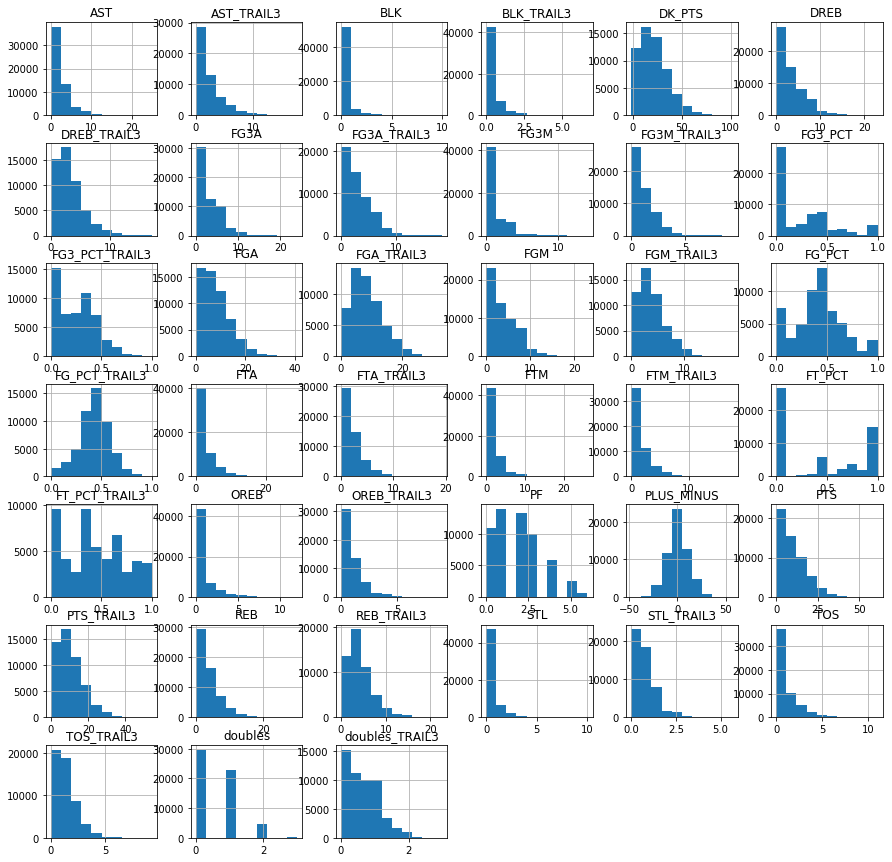

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
stats_sub.hist(ax = ax);

# Get Trailing Averages for Last 5 Games

In [167]:
nba_trailing_5 = []
for season in set(nba_df_played['SEASON_ID']):
    for player in set(nba_df_played['PLAYER_ID']):
        games_played = nba_df_played[(nba_df_played['PLAYER_ID'] == player) & 
                                     (nba_df_played['SEASON_ID'] == season)]
        games_played = games_played.sort_values(by = ['GAME_ID'])
        games_played.reset_index(drop = True, inplace = True)
                      
        # Group 1: Field Goals
        get_trailing_avg(games_played, 'FGM', 5)
        get_trailing_avg(games_played, 'FGA', 5)
        get_trailing_avg(games_played, 'FG_PCT', 5)

        # Group 3: Free Throws
        get_trailing_avg(games_played, 'FTM', 5)
        get_trailing_avg(games_played, 'FTA', 5)
        get_trailing_avg(games_played, 'FT_PCT', 5)

        # Group 4: Rebounds
        get_trailing_avg(games_played, 'REB', 5)
        
        # Group 5: Miscellaneous
        get_trailing_avg(games_played, 'PTS', 5)
        get_trailing_avg(games_played, 'STL', 5)
        get_trailing_avg(games_played, 'AST', 5)            
        get_trailing_avg(games_played, 'BLK', 5)
        get_trailing_avg(games_played, 'TOS', 5)
        get_trailing_avg(games_played, 'SEC', 5)
                      
        nba_trailing_5.append(games_played)

In [171]:
nba_trailing_5_df = pd.concat(nba_trailing_5)

In [222]:
nba_trailing_5_df.reset_index(drop = True, inplace = True)

In [223]:
nba_trailing_5_df = nba_trailing_5_df.replace({'game1': None, 'game2': None, 'game3': None, 'game4': None, 'game5': None})

In [226]:
trailing_5 = nba_trailing_5_df[['FGM_TRAIL5', 'FGA_TRAIL5', 'FG_PCT_TRAIL5', 
                                'FTM_TRAIL5', 'FTA_TRAIL5', 'FT_PCT_TRAIL5', 
                                'REB_TRAIL5', 'PTS_TRAIL5', 'STL_TRAIL5',
                                'AST_TRAIL5', 'BLK_TRAIL5', 'TOS_TRAIL5', 
                                'SEC_TRAIL5', 'DK_PTS']]

In [228]:
trailing_5.dropna(inplace = True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [232]:
trailing_5.reset_index(drop = True, inplace = True)

In [246]:
corr_5 = trailing_5[['REB_TRAIL5', 'STL_TRAIL5',
                     'AST_TRAIL5', 'TOS_TRAIL5', 
                     'SEC_TRAIL5', 'DK_PTS']].corr()

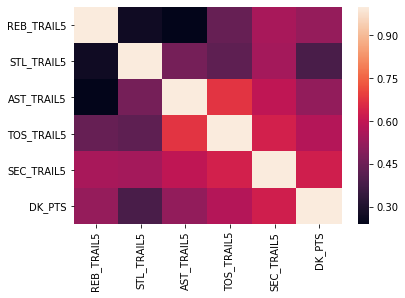

In [247]:
sns.heatmap(corr_5)

In [248]:
corr_unstack = corr_5.unstack()
sorted_corr = corr_unstack.sort_values(kind="quicksort")

corr_df = pd.DataFrame(sorted_corr)
corr_df.columns = ['correlation']
print(corr_df[(corr_df['correlation'].abs() > 0.3) & (corr_df['correlation'].abs() < 1)])
corr_df_index = corr_df.reset_index()

                       correlation
DK_PTS     STL_TRAIL5     0.387528
STL_TRAIL5 DK_PTS         0.387528
TOS_TRAIL5 STL_TRAIL5     0.425702
STL_TRAIL5 TOS_TRAIL5     0.425702
REB_TRAIL5 TOS_TRAIL5     0.440764
TOS_TRAIL5 REB_TRAIL5     0.440764
STL_TRAIL5 AST_TRAIL5     0.466802
AST_TRAIL5 STL_TRAIL5     0.466802
           DK_PTS         0.516444
DK_PTS     AST_TRAIL5     0.516444
           REB_TRAIL5     0.523032
REB_TRAIL5 DK_PTS         0.523032
SEC_TRAIL5 STL_TRAIL5     0.549349
STL_TRAIL5 SEC_TRAIL5     0.549349
REB_TRAIL5 SEC_TRAIL5     0.556777
SEC_TRAIL5 REB_TRAIL5     0.556777
DK_PTS     TOS_TRAIL5     0.576937
TOS_TRAIL5 DK_PTS         0.576937
AST_TRAIL5 SEC_TRAIL5     0.596984
SEC_TRAIL5 AST_TRAIL5     0.596984
DK_PTS     SEC_TRAIL5     0.630390
SEC_TRAIL5 DK_PTS         0.630390
TOS_TRAIL5 SEC_TRAIL5     0.636245
SEC_TRAIL5 TOS_TRAIL5     0.636245
AST_TRAIL5 TOS_TRAIL5     0.678924
TOS_TRAIL5 AST_TRAIL5     0.678924


In [252]:
lm_attempt3 = trailing_5[['REB_TRAIL5', 'STL_TRAIL5',
                     'AST_TRAIL5', 'TOS_TRAIL5', 
                     'SEC_TRAIL5', 'DK_PTS']]
outcome = 'DK_PTS'
Y3 = lm_attempt3[['DK_PTS']]
predictors3 = lm_attempt3.drop('DK_PTS', axis=1)
pred_sum = "+".join(predictors3.columns)
formula = outcome + "~" + pred_sum

In [253]:
model = ols(formula=formula, data=lm_attempt3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DK_PTS   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     9840.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:32:27   Log-Likelihood:            -1.8734e+05
No. Observations:               50109   AIC:                         3.747e+05
Df Residuals:                   50103   BIC:                         3.747e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3553      0.132     -2.702      0.007      -0.613      -0.098
REB_TRAIL5     1.2870      0.020     63.484      0.000       1.247       1.327
STL_TRAIL5     0.4937      0.098      5.049      0.000       0.302       0.685
AST_TRAIL5     1.2146      0.034     36.221      0.000       1.149       1.280
TOS_TRAIL5     2.5406      0.072     35.285      0.000       2.399       2.682
SEC_TRAIL5     0.0074      0.000     52.880      0.000       0.007       0.008
==============================================================================
Omnibus:                     2557.621   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3388.855
Skew:                           0.499   Prob(JB):                         0.00
Kurtosis:                       3.791   Cond. No.                     4.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""